# train.ipynb

This notebook synthesises the process of retraining the Oceania ranking model. You may find many of the R&D ideas helpful in the `dev.ipynb` file.

In [1]:
from train import *

#### 1. Initialised H2O instance

In [2]:
h2o.init(nthreads=-1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 40 mins
H2O_cluster_timezone:,Australia/Brisbane
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,"1 year, 9 months and 29 days !!!"
H2O_cluster_name:,H2O_from_python_mleong_9de43x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.462 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


#### 2. Import Data
In this model version, the data only contained the top 20 variables. Adding new variables will require significant development time with IT and Earnix.

In [3]:
import_cls = import_data('2.Model_refit_Earnixlog.sql')
df = import_cls.df

In [4]:
df = assign_target(df)

#### 3. Count labels
Count the proportion of positive and negative classes before the split.

In [5]:
df['target'].value_counts(normalize=True)

0    0.6206
1    0.3794
Name: target, dtype: float64

About 38% of the quotes are ranked first on CTM, including error in low kilometer banding.

#### 4. Train test split
`sklearn-stratified-split` is used to split the data and ensure the `train_set` and `test_set` have the same distribution (e.g. similar proportion of classes in both data set).

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                     df,
                                     df['target'],
                                     test_size=0.3, 
                                     random_state=42,
                                     stratify = df['target']
                                                  )
X_train['target'].value_counts(normalize=True)
X_test['target'].value_counts(normalize=True)

0    0.620616
1    0.379384
Name: target, dtype: float64

The test set conforms with the distribution of the data before splitting.<br>

Pandas data frame is converted into an h2o frame before passing into the H2O cluster for training.

In [7]:
X_train['weight'] = class_weight.compute_sample_weight( class_weight='balanced', y=X_train['target'])
hf_train = h2o_frame(X_train)
hf_valid = h2o_frame(X_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


#### 5. Training Model

In [82]:
model = H2OGradientBoostingEstimator(seed=42)

model.train(y='target',
        weights_column='weight',
        training_frame= hf_train,
        validation_frame= hf_valid,
        model_id='refit'
        )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


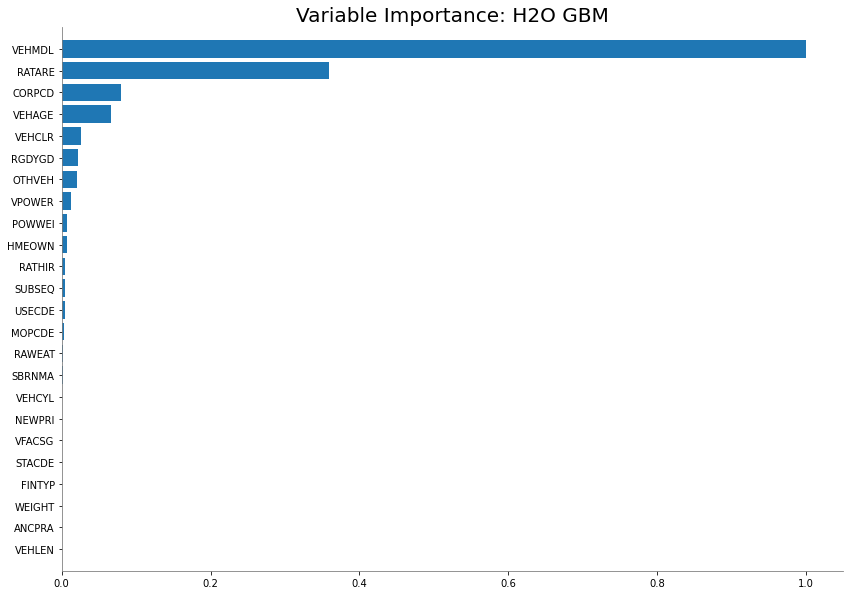

In [83]:
model.varimp_plot(num_of_features=38)
#model.varimp(use_pandas=True).to_csv(lg.root_logdir/'APRIL_v0.csv')

Checking for any sign of overfitting, e.g. divergence in logloss function.

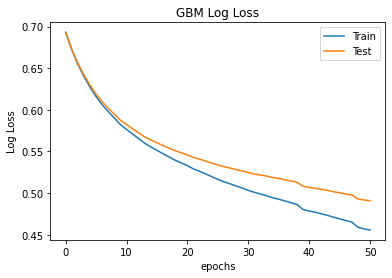

In [77]:
plt_learning_curve(model)

save to the model or the MOJO to production folder

In [78]:
lg.dump_mojo(model, production=True)

model saved in  scoring\MOJO_PROD\2022_03_30.zip


#### 6. Out-of-time test

Instead of sampling from the same period, we perform an out-of-sample test with data ahead of the cutoff time. This prudent time-test allows us to be sure the model will perform in the future, on data it has yet seen.

Over time, the false positive (FP) rate is monitored as a crucial indicator of self-cannibalisation, e.g. quote that rank first in actual is predicted to be not. The false-positive rate is defined as $\frac{FP}{FP+TN}$, where TN is the true negative class.

Factors that influence cannibalisation rate include FP rate, cutoff percentile, and allowable margin of discount.

In [69]:
import_cls = import_data('3.Scoring_Earnixlog.sql')
df_test = import_cls.df 

df_test = assign_target(df_test)
hf_test = h2o_frame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [87]:
from scoring.predict import retrieve_models

model_history = retrieve_models()   

generic Model Build progress: |███████████████████████████████████████████| 100%
generic Model Build progress: |███████████████████████████████████████████| 100%


##### How to adjust the Percentile cut

- $\delta_0$ - Current discounted proportion of the portfolio post underwriting criteria
- $\tau_0$ - Current threshold that resulted $\delta_0$
- $\delta_1$ - desired percentage of Quotes to be discounted post underwriting criteria
 - $\tau_1$ - Threshold to be adjusted to

### $\tau_1$ = $\frac{\delta_1  \tau_0}{\delta_0}$

then set replace the below paramter with:<br>
` model_eval(model_history, hf_test, BottomPercentile=𝜏1)`


In [88]:
from Evaluation import model_eval
metric = model_eval(model_history, hf_test, BottomPercentile=40)

generic prediction progress: |████████████████████████████████████████████| 100%
0.32777333878088777
generic prediction progress: |████████████████████████████████████████████| 100%
0.35901945610869135


**Warning:** The evaluation should be done with out-of-sample (future) data. Due to limited data available we evaluate with data of the same month hence result may be better than expected.

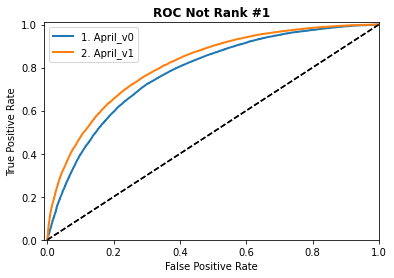

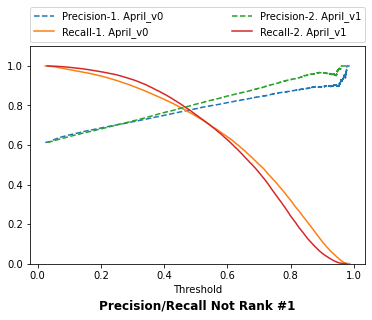

>>>>>>>>>> BINARY MODEL:1. April_v0 with bottom 40th percentile <<<<<<<<<
>>>>>>>>>> Confusion Matrix <<<<<<<<<
[[27493  5626]
 [23917 28647]]
>>>>>>>>>> Metric @ 1. April_v0  <<<<<<<<<
ROC_AUC   : 77.66%
False +ve : 16.99%
Precision : 83.58%
Accuracy  : 65.52%
Miss Rate : 45.50%


>>>>>>>>>> BINARY MODEL:2. April_v1 with bottom 40th percentile <<<<<<<<<
>>>>>>>>>> Confusion Matrix <<<<<<<<<
[[28437  4682]
 [22973 29591]]
>>>>>>>>>> Metric @ 2. April_v1  <<<<<<<<<
ROC_AUC   : 81.21%
False +ve : 14.14%
Precision : 86.34%
Accuracy  : 67.72%
Miss Rate : 43.70%


generic prediction progress: |████████████████████████████████████████████| 100%
0.32777333878088777
generic prediction progress: |████████████████████████████████████████████| 100%
0.35901945610869135
******* After Consider for Margin equal to or more than -3% *******
>>>>>>>>>> BINARY MODEL:1. April_v0 with bottom 40th percentile <<<<<<<<<
>>>>>>>>>> Confusion Matrix <<<<<<<<<
[[29611  3508]
 [30986 21578]]
>>>>>>>>>> Metric @ 1

In [89]:
metric.models_stats()

The allowable margin criteria are underwriting decisions that overlay on top of the model to prevent undesirable profit erosion, resulting in lower false postive at the expense of higher miss rate.

In [90]:
h2o.shutdown()

H2O session _sid_a888 was not closed properly.
